In [3]:
# %% 
# Cell 1: Imports and DB Engine Setup

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import contextily as ctx
# import holoviews as hv
import geoviews as gv
import cartopy.crs as ccrs

from sqlalchemy import create_engine, text
import numpy as np
import psycopg2

# -------------------------------------
# Database Configuration (Postgres)
# -------------------------------------
db_config = {
    'host': '143.248.230.55',
    'port': '5432',
    'dbname': 'AIS_DB_Prototype',
    'user': 'root',
    'password': 'password'
}

# Build SQLAlchemy engine
database_url = (
    f"postgresql://{db_config['user']}:{db_config['password']}"
    f"@{db_config['host']}:{db_config['port']}/{db_config['dbname']}"
)
engine = create_engine(database_url)

In [4]:
# %% 
# Cell 2: Helper Functions to Load Trajectories (fixed ORDER BY RANDOM with DISTINCT)

def load_container_to_busan_voyages(sample_n: int = 5) -> pd.DataFrame:
    """
    Fetch a random sample of voyages (mmsi, eta, destination, shiptype)
    where shiptype ILIKE '%CONTAINER%' and destination ILIKE '%BUSAN%'.
    Uses a subquery to allow DISTINCT with ORDER BY RANDOM().
    """
    sql = text("""
        SELECT sub.mmsi,
               sub.eta_time,
               sub.destination,
               sub.shiptype
        FROM (
            SELECT DISTINCT 
                mmsi,
                CAST(eta AS TIMESTAMP) AS eta_time,
                destination,
                shiptype
            FROM public.ais_korea
            WHERE shiptype ILIKE '%CONTAINER%'
              AND destination ILIKE '%BUSAN%'
        ) AS sub
        ORDER BY RANDOM()
        LIMIT :n;
    """)
    return pd.read_sql(sql, engine, params={"n": sample_n}, parse_dates=["eta_time"])


def load_full_trajectory(mmsi: int, eta_time: pd.Timestamp) -> pd.DataFrame:
    """
    Load ALL AIS points (posutc, latitude, longitude, sog, cog, heading)
    for a given (mmsi, eta) from ais_korea.
    Returns a DataFrame with parsed timestamps.
    """
    sql = text("""
        SELECT 
            posutc AS ts_string,
            latitude,
            longitude,
            sog,
            cog,
            heading
        FROM public.ais_korea
        WHERE mmsi = :m
          AND CAST(eta AS TIMESTAMP) = :e
        ORDER BY posutc::timestamp;
    """)
    df = pd.read_sql(sql, engine, params={"m": mmsi, "e": eta_time})
    df["timestamp"] = pd.to_datetime(df["ts_string"], errors="coerce")
    return df.dropna(subset=["timestamp"])

In [5]:
# %% 
# Cell 3: Plotting Functions (unchanged)

def plot_static_trajectory(mmsi: int, eta_time: pd.Timestamp):
    """
    Plot the full trajectory (latitude/longitude) of a single vessel as a line,
    overlaid on an OSM basemap.
    """
    df = load_full_trajectory(mmsi, eta_time)
    if df.empty:
        print(f"No AIS points found for MMSI={mmsi}, ETA={eta_time}")
        return

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    )
    gdf_web = gdf.to_crs(epsg=3857)

    # Create a LineString from the sequence of points
    line = LineString(gdf_web.geometry.values.tolist())
    gdf_line = gpd.GeoDataFrame(geometry=[line], crs=gdf_web.crs)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    gdf_line.plot(ax=ax, color="blue", linewidth=2, label="Trajectory")
    # Plot start/end points
    gdf_web.iloc[[0]].plot(ax=ax, color="green", markersize=50, label="Start")
    gdf_web.iloc[[-1]].plot(ax=ax, color="red", markersize=50, label="End")

    # Expand bounds by 10%
    minx, miny, maxx, maxy = gdf_web.total_bounds
    dx, dy = maxx - minx, maxy - miny
    ax.set_xlim(minx - dx * 0.1, maxx + dx * 0.1)
    ax.set_ylim(miny - dy * 0.1, maxy + dy * 0.1)

    # Add basemap
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs=gdf_web.crs.to_string()
    )

    ax.set_title(f"MMSI={mmsi}  |  ETA={eta_time}")
    ax.axis("off")
    ax.legend(loc="upper left")
    plt.tight_layout()
    plt.show()


def plot_interactive_trajectory(mmsi: int, eta_time: pd.Timestamp):
    """
    Interactive map (using GeoViews) showing all AIS points with hover info.
    """
    df = load_full_trajectory(mmsi, eta_time)
    if df.empty:
        print(f"No AIS points for MMSI={mmsi}, ETA={eta_time}")
        return

    traj_points = gv.Points(
        df,
        kdims=["longitude", "latitude"],
        vdims=["timestamp", "sog", "cog", "heading"],
        crs=ccrs.PlateCarree()
    ).opts(
        size=4, color="steelblue", tools=["hover"], alpha=0.7
    )

    tiles = gv.tile_sources.OSM().opts(width=800, height=400)
    overlay = (tiles * traj_points).opts(
        title=f"Interactive Trajectory  |  MMSI={mmsi}  |  ETA={eta_time}"
    )
    return overlay

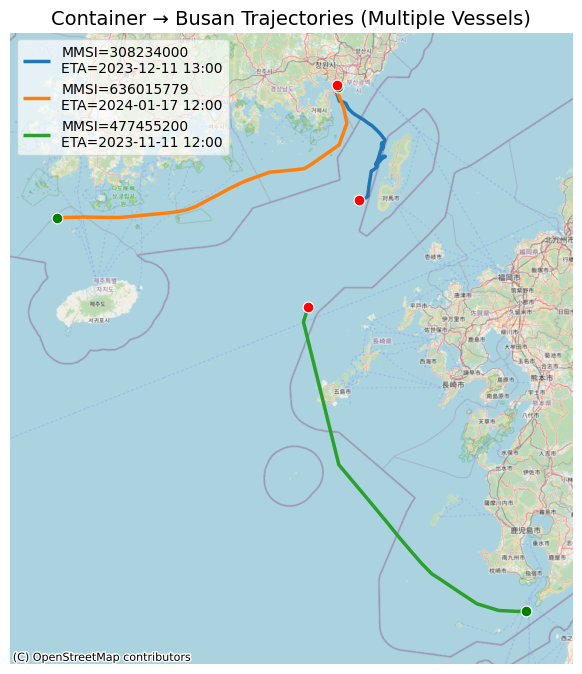

In [9]:
# %% 
# Cell 4: Plot Multiple Container→Busan Trajectories on One Map

# 1) Grab 3 random container-to-busan voyages
#    (You can increase sample_n if you want more vessels on the same map)
voyages_df = load_container_to_busan_voyages(sample_n=3)
voyages_df  # display the sample selection

# 2) Build a combined GeoDataFrame of lines, one per vessel
lines = []
labels = []

for idx, row in voyages_df.iterrows():
    m       = int(row["mmsi"])
    eta_val = row["eta_time"]
    dest    = row["destination"]
    stype   = row["shiptype"]
    
    # Load full trajectory points
    df = load_full_trajectory(m, eta_val)
    if df.empty:
        print(f"— Skipping MMSI={m}, no AIS points found.")
        continue
    
    # Convert to Web Mercator to plot on OSM
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)
    
    # Create a single LineString from all points
    line = LineString(gdf.geometry.values.tolist())
    lines.append(line)
    
    # Use a label like “MMSI 123… | ETA 2024-01-15”
    labels.append(f"MMSI={m}\nETA={eta_val.strftime('%Y-%m-%d %H:%M')}")

# If no lines were built, skip plotting
if not lines:
    print("No valid trajectories to plot.")
else:
    # Create a GeoDataFrame for all lines
    gdf_lines = gpd.GeoDataFrame(
        {"label": labels},
        geometry=lines,
        crs="EPSG:3857"
    )
    
    # 3) Plot all lines on one figure with distinct colors
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Choose a colormap (here 'tab10' which has up to 10 distinct colors)
    cmap = plt.get_cmap("tab10")
    
    for i, row in gdf_lines.iterrows():
        row_gs = gpd.GeoSeries(row.geometry)
        color = cmap(i % 10)
        row_gs.plot(ax=ax, linewidth=2.5, color=color, label=row["label"])
    
    # 4) Plot start/end points for each vessel
    #    We'll plot a small green circle at the first point, and a red circle at the last point.
    for idx, row in voyages_df.iterrows():
        m       = int(row["mmsi"])
        eta_val = row["eta_time"]
        df = load_full_trajectory(m, eta_val)
        if df.empty:
            continue
        
        # Convert to GeoDataFrame and Web Mercator
        gdf_pts = gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df.longitude, df.latitude),
            crs="EPSG:4326"
        ).to_crs(epsg=3857)
        
        # First (start) & last (end) points
        start_pt = gdf_pts.geometry.iloc[0]
        end_pt   = gdf_pts.geometry.iloc[-1]
        
        # Plot start in green, end in red
        ax.scatter(
            [start_pt.x], [start_pt.y],
            s=60, color="green", edgecolor="white", linewidth=0.8, zorder=3
        )
        ax.scatter(
            [end_pt.x], [end_pt.y],
            s=60, color="red", edgecolor="white", linewidth=0.8, zorder=3
        )
    
    # 5) Adjust plot bounds to fit all trajectories
    minx, miny, maxx, maxy = gdf_lines.total_bounds
    dx, dy = maxx - minx, maxy - miny
    ax.set_xlim(minx - dx * 0.1, maxx + dx * 0.1)
    ax.set_ylim(miny - dy * 0.1, maxy + dy * 0.1)
    
    # 6) Add OSM basemap
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs="EPSG:3857"
    )
    
    # 7) Legend and title
    ax.set_title("Container → Busan Trajectories (Multiple Vessels)", fontsize=14)
    ax.axis("off")
    ax.legend(loc="upper left", fontsize=10, framealpha=0.7)
    
    plt.tight_layout()
    plt.show()


In [5]:
# %% 
# Cell 5: (Optional) Save Static Figures to Disk

# Uncomment and tweak the loop below if you want to write PNGs to ./Trajectory_Plots
# import os
# os.makedirs("./Trajectory_Plots", exist_ok=True)
#
# for idx, row in voyages_df.iterrows():
#     m       = int(row["mmsi"])
#     eta_val = row["eta_time"]
#     fig, ax = plt.subplots(figsize=(10,6))
#     df = load_full_trajectory(m, eta_val)
#     gdf = gpd.GeoDataFrame(
#         df, 
#         geometry=gpd.points_from_xy(df.longitude, df.latitude),
#         crs="EPSG:4326"
#     ).to_crs(epsg=3857)
#     line = LineString(gdf.geometry.values.tolist())
#     gdf_line = gpd.GeoDataFrame(geometry=[line], crs=gdf.crs)
#     gdf_line.plot(ax=ax, color="blue", linewidth=2)
#     gdf.iloc[[0]].plot(ax=ax, color="green", markersize=50)
#     gdf.iloc[[-1]].plot(ax=ax, color="red", markersize=50)
#     minx, miny, maxx, maxy = gdf.total_bounds
#     dx, dy = maxx-minx, maxy-miny
#     ax.set_xlim(minx-dx*0.1, maxx+dx*0.1)
#     ax.set_ylim(miny-dy*0.1, maxy+dy*0.1)
#     ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=gdf.crs.to_string())
#     ax.set_title(f\"MMSI={m}  |  ETA={eta_val}\")\n#     ax.axis(\"off\")\n#     plt.tight_layout()\n#     plt.savefig(f\"./Trajectory_Plots/trajectory_{m}_{eta_val.strftime('%Y%m%d_%H%M%S')}.png\")\n#     plt.close()\n\n# print(\"Saved static trajectory plots to ./Trajectory_Plots\")\n```

### How this notebook is organized

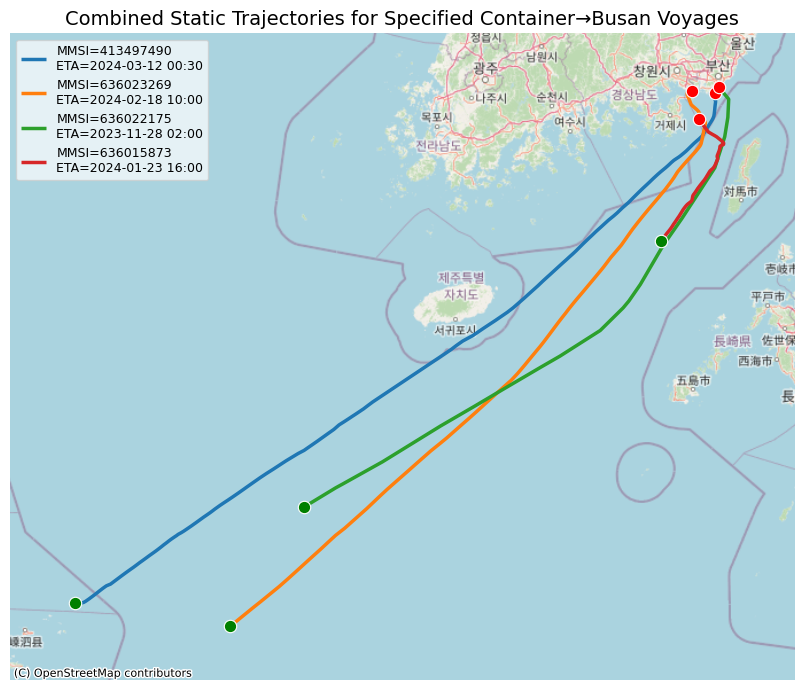

In [14]:
# %% 
# Cell 5: Plot All Four Specified MMSI/ETA Voyages on One Map

import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString

# List of voyages to plot together
specified_voyages = [
    {"mmsi": 413497490, "eta": "2024-03-12 00:30:00"},
    {"mmsi": 636023269, "eta": "2024-02-18 10:00:00"},
    {"mmsi": 636022175, "eta": "2023-11-28 02:00:00"},
    {"mmsi": 636015873, "eta": "2024-01-23 16:00:00"},
]

# Collect LineStrings and labels
lines = []
labels = []
start_points = []
end_points = []
colors = plt.get_cmap("tab10")  # up to 10 distinct colors

for idx, v in enumerate(specified_voyages):
    m = int(v["mmsi"])
    e = pd.to_datetime(v["eta"])
    label = f"MMSI={m}\nETA={e.strftime('%Y-%m-%d %H:%M')}"
    
    # Load the full trajectory DataFrame
    df = load_full_trajectory(m, e)
    if df is None or df.empty:
        print(f"⚠️ No AIS points for MMSI={m}, ETA={e}, skipping.")
        continue
    
    # Convert to GeoDataFrame in Web Mercator
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)
    
    # Build a LineString through all points
    line = LineString(gdf.geometry.values.tolist())
    lines.append(line)
    labels.append(label)
    
    # Save start/end as Point geometries
    start_points.append(gdf.geometry.iloc[0])
    end_points.append(gdf.geometry.iloc[-1])

# If none, bail out
if not lines:
    print("No valid voyages to plot.")
else:
    # Put all LineStrings into one GeoDataFrame
    gdf_lines = gpd.GeoDataFrame(
        {"label": labels},
        geometry=lines,
        crs="EPSG:3857"
    )
    
    # Create a GeoSeries for start/end markers
    gdf_starts = gpd.GeoSeries(start_points, crs="EPSG:3857")
    gdf_ends   = gpd.GeoSeries(end_points, crs="EPSG:3857")
    
    # Plot all together
    fig, ax = plt.subplots(figsize=(12, 7))
    
    for i, row in gdf_lines.iterrows():
        color = colors(i % 10)
        gpd.GeoSeries(row.geometry).plot(
            ax=ax,
            linewidth=2.5,
            color=color,
            label=row["label"]
        )
    
    # Plot start (green) and end (red) for each line
    for i in range(len(gdf_starts)):
        ax.scatter(
            gdf_starts[i].x, gdf_starts[i].y,
            s=80, color="green", edgecolor="white", linewidth=0.8, zorder=3
        )
        ax.scatter(
            gdf_ends[i].x, gdf_ends[i].y,
            s=80, color="red",   edgecolor="white", linewidth=0.8, zorder=3
        )
    
    # Adjust bounds to include all trajectories
    minx, miny, maxx, maxy = gdf_lines.total_bounds
    dx, dy = maxx - minx, maxy - miny
    ax.set_xlim(minx - dx * 0.1, maxx + dx * 0.1)
    ax.set_ylim(miny - dy * 0.1, maxy + dy * 0.1)
    
    # Add OSM basemap underneath
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs="EPSG:3857"
    )
    
    # Final touches
    ax.set_title("Combined Static Trajectories for Specified Container→Busan Voyages", fontsize=14)
    ax.axis("off")
    ax.legend(loc="upper left", fontsize=9, framealpha=0.7)
    plt.tight_layout()
    plt.show()


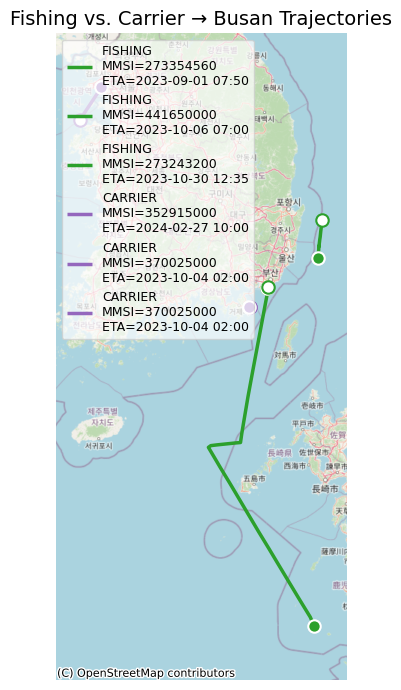

In [16]:
# %% 
# Cell 6: Plot Static Trajectories for “Fishing” and “Carrier” Voyages (fixed)

import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString
from sqlalchemy import text

def load_voyages_by_type_and_dest(shiptype_keyword: str, dest_keyword: str, sample_n: int = 3) -> pd.DataFrame:
    """
    Fetch a random sample of voyages (mmsi, eta, destination, shiptype)
    where shiptype ILIKE '%shiptype_keyword%' and destination ILIKE '%dest_keyword%'.
    Uses a subquery to allow DISTINCT with ORDER BY RANDOM().
    """
    sql = text("""
        SELECT sub.mmsi,
               sub.eta_time,
               sub.destination,
               sub.shiptype
        FROM (
            SELECT DISTINCT
                mmsi,
                CAST(eta AS TIMESTAMP) AS eta_time,
                destination,
                shiptype
            FROM public.ais_korea
            WHERE shiptype ILIKE :stype
              AND destination ILIKE :dest
        ) AS sub
        ORDER BY RANDOM()
        LIMIT :n;
    """)
    return pd.read_sql(
        sql, engine,
        params={
            "stype": f"%{shiptype_keyword}%",
            "dest":  f"%{dest_keyword}%",
            "n":      sample_n
        },
        parse_dates=["eta_time"]
    )

# Example usage: sample 3 “FISHING”→“BUSAN” and 3 “CARRIER”→“BUSAN”
fishing_voyages = load_voyages_by_type_and_dest("FISHING", "BUSAN", sample_n=3)
carrier_voyages = load_voyages_by_type_and_dest("CARRIER", "BUSAN", sample_n=3)

# Combine into one DataFrame with a “group” column
combined = pd.concat([
    fishing_voyages.assign(group="FISHING"),
    carrier_voyages.assign(group="CARRIER")
], ignore_index=True)

# Prepare lists for geometries, labels, start/end markers
lines = []
labels = []
start_points = []
end_points = []
colors = {"FISHING": "tab:green", "CARRIER": "tab:purple"}

for idx, row in combined.iterrows():
    m = int(row["mmsi"])
    e = row["eta_time"]
    grp = row["group"]
    label = f"{grp}\nMMSI={m}\nETA={e.strftime('%Y-%m-%d %H:%M')}"

    # Load the full trajectory DataFrame
    df = load_full_trajectory(m, e)
    if df is None or len(df) < 2:
        # Skip if there are fewer than 2 valid points
        print(f"⚠️ Skipping MMSI={m} ({grp}), not enough AIS points.")
        continue

    # Convert to GeoDataFrame in Web Mercator
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    # Build a LineString through all points
    line = LineString(gdf.geometry.values.tolist())
    lines.append((line, grp))
    labels.append(label)

    # Record start/end as Point geometries
    start_points.append(gdf.geometry.iloc[0])
    end_points.append(gdf.geometry.iloc[-1])

if lines:
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot each line using its group color
    for i, (geometry, grp) in enumerate(lines):
        color = colors.get(grp, "tab:gray")
        gpd.GeoSeries([geometry], crs="EPSG:3857").plot(
            ax=ax, color=color, linewidth=2.5, label=labels[i]
        )

    # Plot start (white‐filled, edged with group color) and end (group color, edged white)
    for i in range(len(start_points)):
        sp = start_points[i]
        ep = end_points[i]
        grp = lines[i][1]
        col = colors.get(grp, "tab:gray")

        ax.scatter(
            sp.x, sp.y,
            s=80, color="white", edgecolor=col, linewidth=1.5, zorder=3
        )
        ax.scatter(
            ep.x, ep.y,
            s=80, color=col, edgecolor="white", linewidth=1.5, zorder=3
        )

    # Adjust bounds to include all trajectories
    all_bounds = gpd.GeoSeries([geom for geom, _ in lines], crs="EPSG:3857").total_bounds
    minx, miny, maxx, maxy = all_bounds
    dx, dy = maxx - minx, maxy - miny
    ax.set_xlim(minx - dx * 0.1, maxx + dx * 0.1)
    ax.set_ylim(miny - dy * 0.1, maxy + dy * 0.1)

    # Add OSM basemap underneath
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs="EPSG:3857"
    )

    ax.set_title("Fishing vs. Carrier → Busan Trajectories", fontsize=14)
    ax.axis("off")
    ax.legend(loc="upper left", fontsize=9, framealpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No valid Fishing/Carrier voyages to plot.")


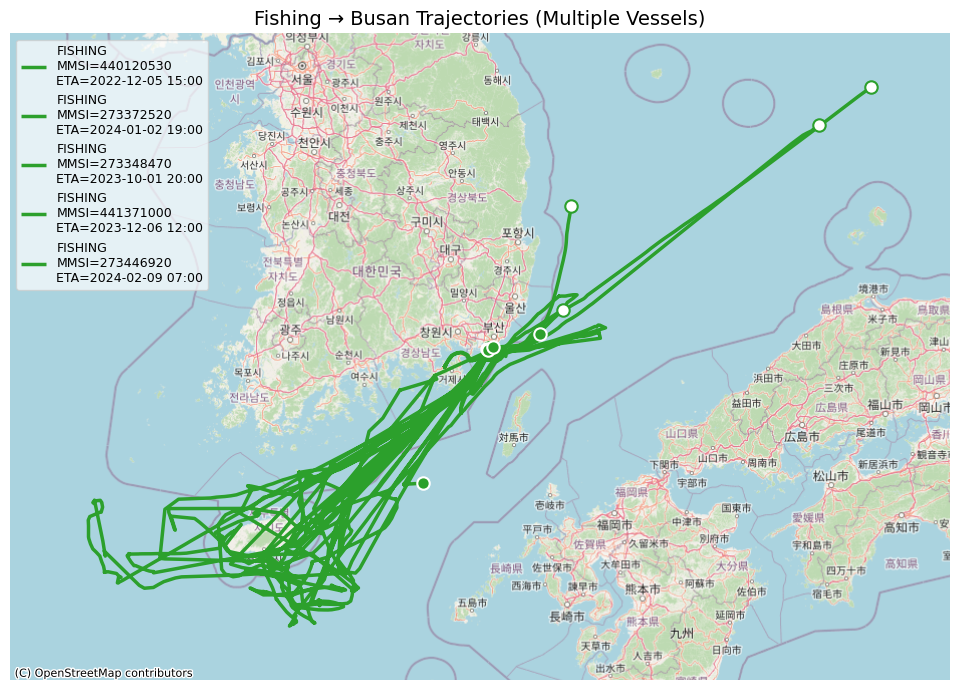

In [17]:
# %% 
# Cell 6: Plot Static Trajectories for “Fishing” Voyages Only

import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString
from sqlalchemy import text

def load_voyages_by_type_and_dest(shiptype_keyword: str, dest_keyword: str, sample_n: int = 3) -> pd.DataFrame:
    """
    Fetch a random sample of voyages (mmsi, eta, destination, shiptype)
    where shiptype ILIKE '%shiptype_keyword%' and destination ILIKE '%dest_keyword%'.
    Uses a subquery to allow DISTINCT with ORDER BY RANDOM().
    """
    sql = text("""
        SELECT sub.mmsi,
               sub.eta_time,
               sub.destination,
               sub.shiptype
        FROM (
            SELECT DISTINCT
                mmsi,
                CAST(eta AS TIMESTAMP) AS eta_time,
                destination,
                shiptype
            FROM public.ais_korea
            WHERE shiptype ILIKE :stype
              AND destination ILIKE :dest
        ) AS sub
        ORDER BY RANDOM()
        LIMIT :n;
    """)
    return pd.read_sql(
        sql, engine,
        params={
            "stype": f"%{shiptype_keyword}%",
            "dest":  f"%{dest_keyword}%",
            "n":      sample_n
        },
        parse_dates=["eta_time"]
    )

# Example usage: sample 5 “FISHING”→“BUSAN” voyages
fishing_voyages = load_voyages_by_type_and_dest("FISHING", "BUSAN", sample_n=5)

# Prepare lists for geometries, labels, start/end markers
lines = []
labels = []
start_points = []
end_points = []
color = "tab:green"  # use a single color for all fishing trajectories

for idx, row in fishing_voyages.iterrows():
    m = int(row["mmsi"])
    e = row["eta_time"]
    label = f"FISHING\nMMSI={m}\nETA={e.strftime('%Y-%m-%d %H:%M')}"

    # Load the full trajectory DataFrame
    df = load_full_trajectory(m, e)
    if df is None or len(df) < 2:
        # Skip if there are fewer than 2 valid points
        print(f"⚠️ Skipping MMSI={m} (FISHING), not enough AIS points.")
        continue

    # Convert to GeoDataFrame in Web Mercator
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    # Build a LineString through all points
    line = LineString(gdf.geometry.values.tolist())
    lines.append(line)
    labels.append(label)

    # Record start/end as Point geometries
    start_points.append(gdf.geometry.iloc[0])
    end_points.append(gdf.geometry.iloc[-1])

if lines:
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot each fishing line in the same color
    for i, geometry in enumerate(lines):
        gpd.GeoSeries([geometry], crs="EPSG:3857").plot(
            ax=ax, color=color, linewidth=2.5, label=labels[i]
        )

    # Plot start (white-filled with green edge) and end (green with white edge)
    for i in range(len(start_points)):
        sp = start_points[i]
        ep = end_points[i]

        ax.scatter(
            sp.x, sp.y,
            s=80, color="white", edgecolor=color, linewidth=1.5, zorder=3
        )
        ax.scatter(
            ep.x, ep.y,
            s=80, color=color, edgecolor="white", linewidth=1.5, zorder=3
        )

    # Adjust bounds to include all trajectories
    all_bounds = gpd.GeoSeries(lines, crs="EPSG:3857").total_bounds
    minx, miny, maxx, maxy = all_bounds
    dx, dy = maxx - minx, maxy - miny
    ax.set_xlim(minx - dx * 0.1, maxx + dx * 0.1)
    ax.set_ylim(miny - dy * 0.1, maxy + dy * 0.1)

    # Add OSM basemap underneath
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs="EPSG:3857"
    )

    ax.set_title("Fishing → Busan Trajectories (Multiple Vessels)", fontsize=14)
    ax.axis("off")
    ax.legend(loc="upper left", fontsize=9, framealpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No valid Fishing voyages to plot.")


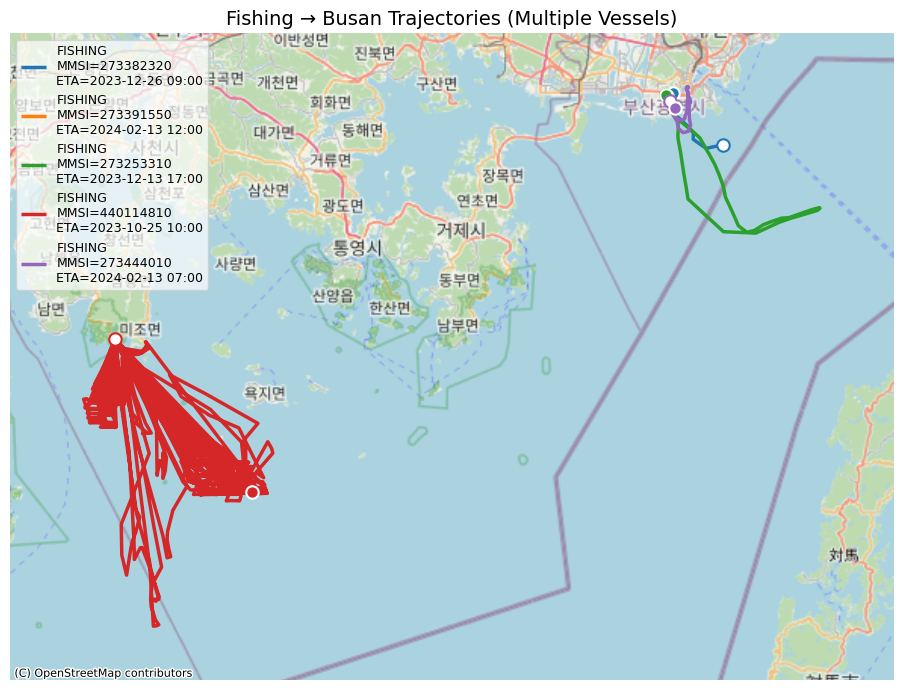

In [18]:
# %% 
# Cell 6: Plot Static Trajectories for “Fishing” Voyages Only (each MMSI in a unique color)

import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString
from sqlalchemy import text
import numpy as np

def load_voyages_by_type_and_dest(shiptype_keyword: str, dest_keyword: str, sample_n: int = 3) -> pd.DataFrame:
    """
    Fetch a random sample of voyages (mmsi, eta, destination, shiptype)
    where shiptype ILIKE '%shiptype_keyword%' and destination ILIKE '%dest_keyword%'.
    Uses a subquery to allow DISTINCT with ORDER BY RANDOM().
    """
    sql = text("""
        SELECT sub.mmsi,
               sub.eta_time,
               sub.destination,
               sub.shiptype
        FROM (
            SELECT DISTINCT
                mmsi,
                CAST(eta AS TIMESTAMP) AS eta_time,
                destination,
                shiptype
            FROM public.ais_korea
            WHERE shiptype ILIKE :stype
              AND destination ILIKE :dest
        ) AS sub
        ORDER BY RANDOM()
        LIMIT :n;
    """)
    return pd.read_sql(
        sql, engine,
        params={
            "stype": f"%{shiptype_keyword}%",
            "dest":  f"%{dest_keyword}%",
            "n":      sample_n
        },
        parse_dates=["eta_time"]
    )

# Example usage: sample 5 “FISHING”→“BUSAN” voyages
fishing_voyages = load_voyages_by_type_and_dest("FISHING", "BUSAN", sample_n=5)

# Prepare lists for geometries, labels, start/end markers
lines = []
labels = []
start_points = []
end_points = []

for idx, row in fishing_voyages.iterrows():
    m = int(row["mmsi"])
    e = row["eta_time"]
    label = f"FISHING\nMMSI={m}\nETA={e.strftime('%Y-%m-%d %H:%M')}"
    
    # Load the full trajectory DataFrame
    df = load_full_trajectory(m, e)
    if df is None or len(df) < 2:
        # Skip if fewer than 2 valid points
        print(f"⚠️ Skipping MMSI={m} (FISHING), not enough AIS points.")
        continue
    
    # Convert to GeoDataFrame in Web Mercator
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)
    
    # Build a LineString through all points
    line = LineString(gdf.geometry.values.tolist())
    lines.append(line)
    labels.append(label)
    
    # Record start/end as Point geometries
    start_points.append(gdf.geometry.iloc[0])
    end_points.append(gdf.geometry.iloc[-1])

if lines:
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Choose a colormap with enough distinct colors
    cmap = plt.get_cmap("tab10")
    num_lines = len(lines)
    colors = [cmap(i % 10) for i in range(num_lines)]
    
    # Plot each fishing line with its own color
    for i, geometry in enumerate(lines):
        gpd.GeoSeries([geometry], crs="EPSG:3857").plot(
            ax=ax,
            color=colors[i],
            linewidth=2.5,
            label=labels[i]
        )
    
    # Plot start (white-filled, edged with line color) and end (filled with line color)
    for i in range(num_lines):
        sp = start_points[i]
        ep = end_points[i]
        col = colors[i]
        
        ax.scatter(
            sp.x, sp.y,
            s=80, color="white", edgecolor=col, linewidth=1.5, zorder=3
        )
        ax.scatter(
            ep.x, ep.y,
            s=80, color=col, edgecolor="white", linewidth=1.5, zorder=3
        )
    
    # Adjust bounds to include all trajectories
    all_bounds = gpd.GeoSeries(lines, crs="EPSG:3857").total_bounds
    minx, miny, maxx, maxy = all_bounds
    dx, dy = maxx - minx, maxy - miny
    ax.set_xlim(minx - dx * 0.1, maxx + dx * 0.1)
    ax.set_ylim(miny - dy * 0.1, maxy + dy * 0.1)
    
    # Add OSM basemap underneath
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs="EPSG:3857"
    )
    
    ax.set_title("Fishing → Busan Trajectories (Multiple Vessels)", fontsize=14)
    ax.axis("off")
    ax.legend(loc="upper left", fontsize=9, framealpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No valid Fishing voyages to plot.")


⚠️ Skipping MMSI=273391550, not enough AIS points.


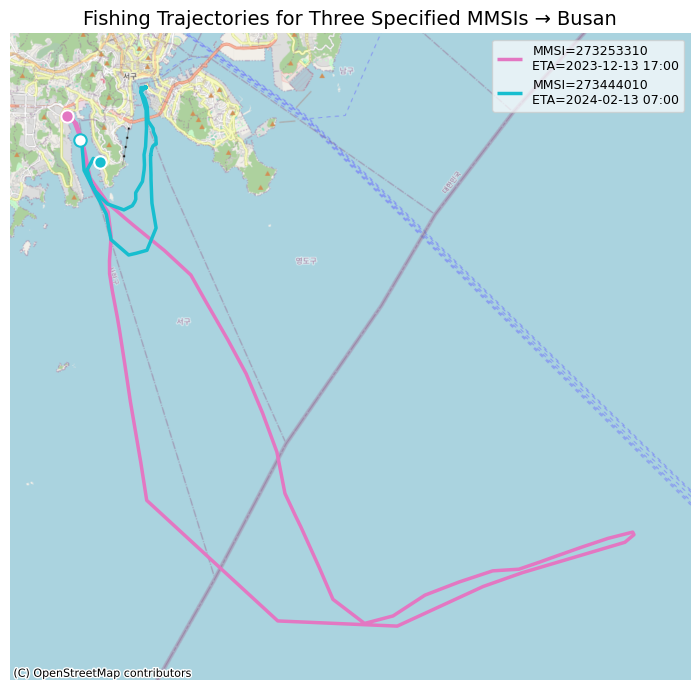

In [21]:
# %% 
# Cell 7: Plot Static Trajectories for Three Specified Voyages on One Map

import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd

# List of three voyages to plot together
specified_voyages = [
    {"mmsi": 273253310, "eta": "2023-12-13 17:00:00"},
    {"mmsi": 273391550, "eta": "2023-12-26 09:00:00"},
    {"mmsi": 273444010, "eta": "2024-02-13 07:00:00"},
]

# Assign a distinct color to each MMSI
colors = ["#e377c2", "#17becf", "#9467bd"]  # (example: pink, teal, purple)

# Prepare lists for line geometries, labels, and start/end markers
lines = []
labels = []
start_points = []
end_points = []

for i, v in enumerate(specified_voyages):
    m = int(v["mmsi"])
    e = pd.to_datetime(v["eta"])
    label = f"MMSI={m}\nETA={e.strftime('%Y-%m-%d %H:%M')}"

    # Load the full trajectory (assumes load_full_trajectory is already defined)
    df = load_full_trajectory(m, e)
    if df is None or len(df) < 2:
        print(f"⚠️ Skipping MMSI={m}, not enough AIS points.")
        continue

    # Convert to GeoDataFrame in Web Mercator (EPSG:3857)
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    # Build a LineString through all points
    line = LineString(gdf.geometry.values.tolist())
    lines.append(line)
    labels.append(label)

    # Record the start and end point as Point geometries
    start_points.append(gdf.geometry.iloc[0])
    end_points.append(gdf.geometry.iloc[-1])

if lines:
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot each trajectory with its assigned color
    for i, geom in enumerate(lines):
        gpd.GeoSeries([geom], crs="EPSG:3857").plot(
            ax=ax,
            color=colors[i],
            linewidth=2.5,
            label=labels[i]
        )

    # Plot start points (white fill, colored edge) and end points (filled colored, white edge)
    for i in range(len(start_points)):
        sp = start_points[i]
        ep = end_points[i]
        col = colors[i]

        ax.scatter(
            sp.x, sp.y,
            s=80,
            color="white",
            edgecolor=col,
            linewidth=1.5,
            zorder=3
        )
        ax.scatter(
            ep.x, ep.y,
            s=80,
            color=col,
            edgecolor="white",
            linewidth=1.5,
            zorder=3
        )

    # Set plot bounds to include all trajectories with 10% padding
    all_bounds = gpd.GeoSeries(lines, crs="EPSG:3857").total_bounds
    minx, miny, maxx, maxy = all_bounds
    dx, dy = maxx - minx, maxy - miny
    ax.set_xlim(minx - dx * 0.1, maxx + dx * 0.1)
    ax.set_ylim(miny - dy * 0.1, maxy + dy * 0.1)

    # Add OpenStreetMap basemap underneath
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs="EPSG:3857"
    )

    ax.set_title("Fishing Trajectories for Three Specified MMSIs → Busan", fontsize=14)
    ax.axis("off")
    ax.legend(loc="upper right", fontsize=9, framealpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No valid voyages to plot.")


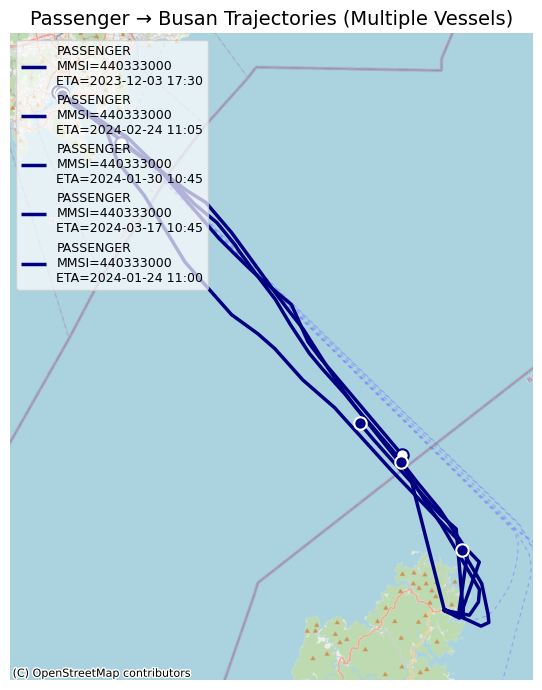

In [22]:
# %% 
# Cell 8: Plot Static Trajectories for “Passenger” Voyages Only

import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString
from sqlalchemy import text
import pandas as pd

def load_passenger_voyages(dest_keyword: str, sample_n: int = 5) -> pd.DataFrame:
    """
    Fetch a random sample of voyages (mmsi, eta, destination, shiptype)
    where shiptype ILIKE '%PASSENGER%' and destination ILIKE '%dest_keyword%'.
    Uses a subquery to allow DISTINCT with ORDER BY RANDOM().
    """
    sql = text("""
        SELECT sub.mmsi,
               sub.eta_time,
               sub.destination,
               sub.shiptype
        FROM (
            SELECT DISTINCT
                mmsi,
                CAST(eta AS TIMESTAMP) AS eta_time,
                destination,
                shiptype
            FROM public.ais_korea
            WHERE shiptype ILIKE '%PASSENGER%'
              AND destination ILIKE :dest
        ) AS sub
        ORDER BY RANDOM()
        LIMIT :n;
    """)
    return pd.read_sql(
        sql, engine,
        params={"dest": f"%{dest_keyword}%", "n": sample_n},
        parse_dates=["eta_time"]
    )

# Example usage: sample 5 “PASSENGER”→“BUSAN” voyages
passenger_voyages = load_passenger_voyages("BUSAN", sample_n=5)

# Prepare lists for geometries, labels, start/end markers
lines = []
labels = []
start_points = []
end_points = []

# Use a distinct color (e.g., navy) for all passenger trajectories
color = "navy"

for idx, row in passenger_voyages.iterrows():
    m = int(row["mmsi"])
    e = row["eta_time"]
    label = f"PASSENGER\nMMSI={m}\nETA={e.strftime('%Y-%m-%d %H:%M')}"

    # Load the full trajectory (assumes load_full_trajectory is already defined)
    df = load_full_trajectory(m, e)
    if df is None or len(df) < 2:
        print(f"⚠️ Skipping MMSI={m} (PASSENGER), not enough AIS points.")
        continue

    # Convert to GeoDataFrame in Web Mercator (EPSG:3857)
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    # Build a LineString through all points
    line = LineString(gdf.geometry.values.tolist())
    lines.append(line)
    labels.append(label)

    # Record the start and end point as Point geometries
    start_points.append(gdf.geometry.iloc[0])
    end_points.append(gdf.geometry.iloc[-1])

if lines:
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot each passenger line in the same color
    for i, geometry in enumerate(lines):
        gpd.GeoSeries([geometry], crs="EPSG:3857").plot(
            ax=ax, color=color, linewidth=2.5, label=labels[i]
        )

    # Plot start (white-filled with navy edge) and end (navy-filled with white edge)
    for i in range(len(start_points)):
        sp = start_points[i]
        ep = end_points[i]

        ax.scatter(
            sp.x, sp.y,
            s=80, color="white", edgecolor=color, linewidth=1.5, zorder=3
        )
        ax.scatter(
            ep.x, ep.y,
            s=80, color=color, edgecolor="white", linewidth=1.5, zorder=3
        )

    # Adjust bounds to include all trajectories
    all_bounds = gpd.GeoSeries(lines, crs="EPSG:3857").total_bounds
    minx, miny, maxx, maxy = all_bounds
    dx, dy = maxx - minx, maxy - miny
    ax.set_xlim(minx - dx * 0.1, maxx + dx * 0.1)
    ax.set_ylim(miny - dy * 0.1, maxy + dy * 0.1)

    # Add OSM basemap underneath
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs="EPSG:3857"
    )

    ax.set_title("Passenger → Busan Trajectories (Multiple Vessels)", fontsize=14)
    ax.axis("off")
    ax.legend(loc="upper left", fontsize=9, framealpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No valid Passenger voyages to plot.")


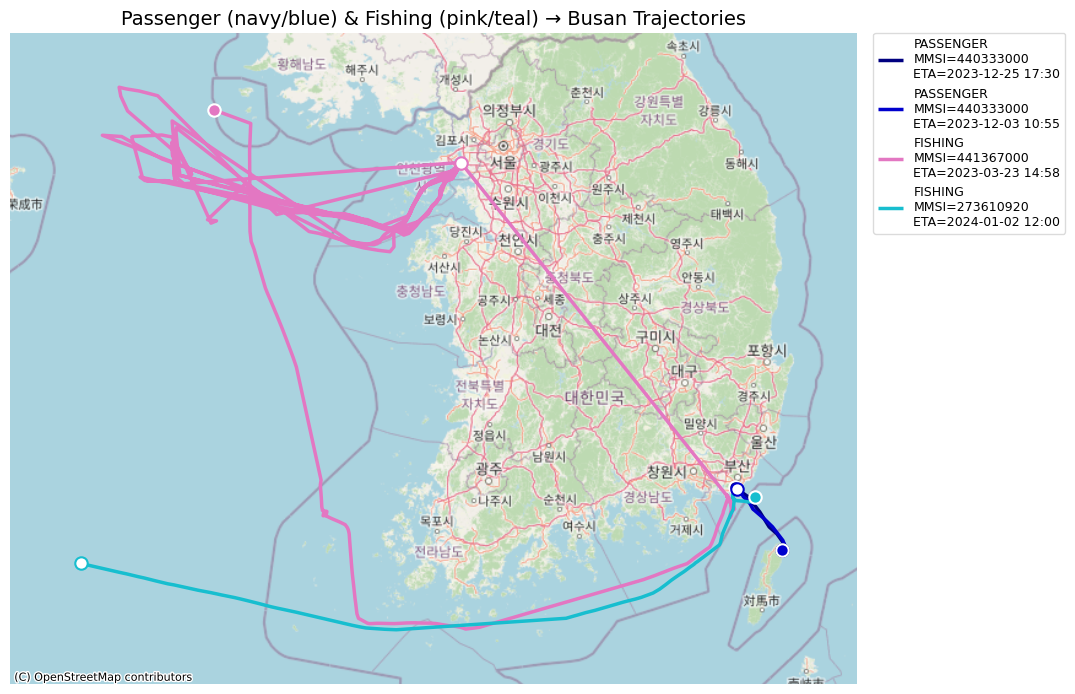

In [23]:
# %% 
# Cell 8: Plot Two “Passenger” and Two “Fishing” Voyages on One Map

import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString
from sqlalchemy import text
import pandas as pd

# Helper to sample voyages by ship type and destination
def load_voyages_by_type_and_dest(shiptype_keyword: str, dest_keyword: str, sample_n: int) -> pd.DataFrame:
    """
    Fetch a random sample of voyages (mmsi, eta, destination, shiptype)
    where shiptype ILIKE '%shiptype_keyword%' and destination ILIKE '%dest_keyword%'.
    Uses a subquery so DISTINCT + ORDER BY RANDOM() works correctly.
    """
    sql = text("""
        SELECT sub.mmsi,
               sub.eta_time,
               sub.destination,
               sub.shiptype
        FROM (
            SELECT DISTINCT
                mmsi,
                CAST(eta AS TIMESTAMP) AS eta_time,
                destination,
                shiptype
            FROM public.ais_korea
            WHERE shiptype ILIKE :stype
              AND destination ILIKE :dest
        ) AS sub
        ORDER BY RANDOM()
        LIMIT :n;
    """)
    return pd.read_sql(
        sql, engine,
        params={
            "stype": f"%{shiptype_keyword}%",
            "dest":  f"%{dest_keyword}%",
            "n":      sample_n
        },
        parse_dates=["eta_time"]
    )

# 1) Sample 2 “PASSENGER”→“BUSAN” and 2 “FISHING”→“BUSAN”
passenger_voyages = load_voyages_by_type_and_dest("PASSENGER", "BUSAN", sample_n=2)
fishing_voyages   = load_voyages_by_type_and_dest("FISHING",   "BUSAN", sample_n=2)

# 2) Combine into one DataFrame, adding a “group” column
passenger_voyages["group"] = "PASSENGER"
fishing_voyages["group"]   = "FISHING"
combined = pd.concat([passenger_voyages, fishing_voyages], ignore_index=True)

# 3) Prepare lists for geometries, labels, start/end markers
lines = []
labels = []
start_points = []
end_points = []

# Assign distinct colors for each vessel: first two are PASSENGER, next two are FISHING
colors = ["navy", "mediumblue", "#e377c2", "#17becf"]  

for i, row in combined.iterrows():
    m = int(row["mmsi"])
    e = row["eta_time"]
    grp = row["group"]
    label = f"{grp}\nMMSI={m}\nETA={e.strftime('%Y-%m-%d %H:%M')}"

    # Load full AIS trajectory for this voyage
    df = load_full_trajectory(m, e)
    if df is None or len(df) < 2:
        print(f"⚠️ Skipping MMSI={m} ({grp}), not enough AIS points.")
        continue

    # Convert to GeoDataFrame in Web Mercator (EPSG:3857)
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    # Build a LineString through all points
    line = LineString(gdf.geometry.values.tolist())
    lines.append(line)
    labels.append(label)

    # Record start/end as Point geometries
    start_points.append(gdf.geometry.iloc[0])
    end_points.append(gdf.geometry.iloc[-1])

if lines:
    fig, ax = plt.subplots(figsize=(12, 8))

    # 4) Plot each vessel’s trajectory with its assigned color
    for i, geom in enumerate(lines):
        color = colors[i]
        gpd.GeoSeries([geom], crs="EPSG:3857").plot(
            ax=ax, color=color, linewidth=2.5, label=labels[i]
        )

    # 5) Plot start (white-filled, edged by line color) and end (filled by line color, edged white)
    for i in range(len(start_points)):
        sp = start_points[i]
        ep = end_points[i]
        col = colors[i]
        ax.scatter(
            sp.x, sp.y,
            s=80, color="white", edgecolor=col, linewidth=1.5, zorder=3
        )
        ax.scatter(
            ep.x, ep.y,
            s=80, color=col, edgecolor="white", linewidth=1.5, zorder=3
        )

    # 6) Adjust plot bounds to include all trajectories + 10% padding
    all_bounds = gpd.GeoSeries(lines, crs="EPSG:3857").total_bounds
    minx, miny, maxx, maxy = all_bounds
    dx, dy = maxx - minx, maxy - miny
    ax.set_xlim(minx - dx * 0.1, maxx + dx * 0.1)
    ax.set_ylim(miny - dy * 0.1, maxy + dy * 0.1)

    # 7) Add OpenStreetMap basemap underneath
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs="EPSG:3857"
    )

    # 8) Final touches: title and legend
    ax.set_title("Passenger (navy/blue) & Fishing (pink/teal) → Busan Trajectories", fontsize=14)
    ax.axis("off")
    ax.legend(
        loc="upper left",
        bbox_to_anchor=(1.02, 1),
        borderaxespad=0.0,
        fontsize=9,
        framealpha=0.7
    )
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
else:
    print("No valid voyages to plot.")


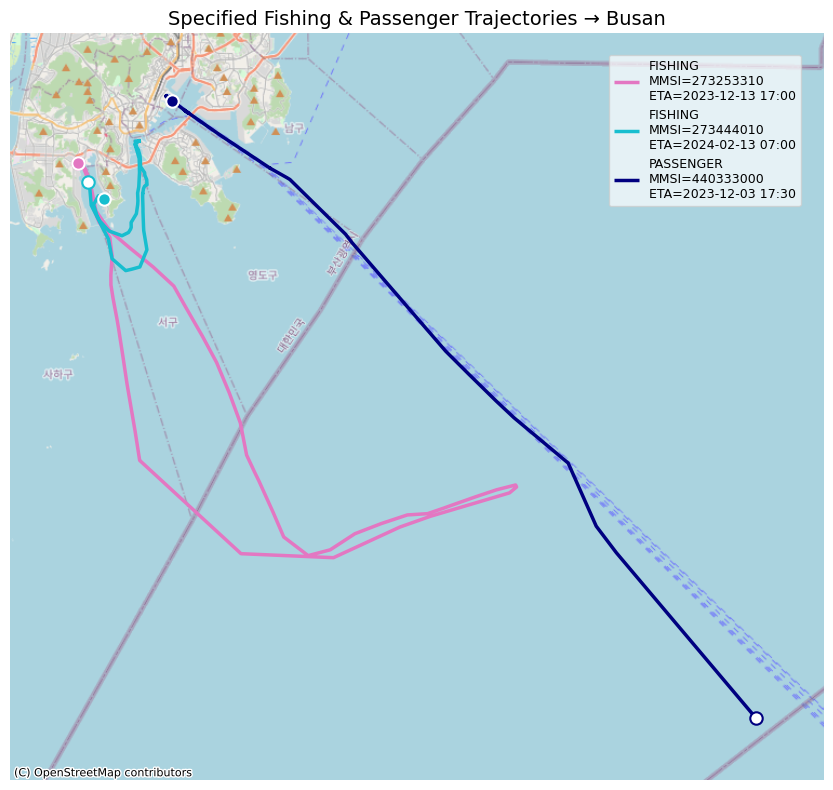

In [25]:
# %% 
# Cell 9 (updated): Plot Two Fishing + One Passenger Trajectories on One Map,
# with legend moved into the top‐right ocean region

import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd

# List of specified voyages (two Fishing → Busan, one Passenger → Busan)
specified_voyages = [
    {"mmsi": 273253310, "eta": "2023-12-13 17:00:00", "type": "FISHING"},
    {"mmsi": 273444010, "eta": "2024-02-13 07:00:00", "type": "FISHING"},
    {"mmsi": 440333000, "eta": "2023-12-03 17:30:00", "type": "PASSENGER"},
]

# Assign a color for each vessel (pink, teal for Fishing; navy for Passenger)
color_map = {
    273253310: "#e377c2",  # pink
    273444010: "#17becf",  # teal
    440333000: "navy"      # navy
}

# Prepare lists for geometries, labels, start/end markers
lines = []
labels = []
start_pts = []
end_pts = []

for v in specified_voyages:
    m = v["mmsi"]
    e = pd.to_datetime(v["eta"])
    grp = v["type"]
    label = f"{grp}\nMMSI={m}\nETA={e.strftime('%Y-%m-%d %H:%M')}"

    # Load the full trajectory (assumes load_full_trajectory is defined already)
    df = load_full_trajectory(m, e)
    if df is None or len(df) < 2:
        print(f"⚠️ Skipping MMSI={m} ({grp}), not enough AIS points.")
        continue

    # Convert to GeoDataFrame (EPSG:4326 → EPSG:3857)
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df.longitude, df.latitude),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    # Build a LineString through all points
    line = LineString(gdf.geometry.values.tolist())
    lines.append((line, m))
    labels.append(label)

    # Record start/end as Points
    start_pts.append(gdf.geometry.iloc[0])
    end_pts.append(gdf.geometry.iloc[-1])

if lines:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot each trajectory with its assigned color
    for idx, (geom, m) in enumerate(lines):
        col = color_map[m]
        gpd.GeoSeries([geom], crs="EPSG:3857").plot(
            ax=ax,
            color=col,
            linewidth=2.5,
            label=labels[idx]
        )

    # Plot start (white fill, colored edge) and end (colored fill, white edge)
    for idx, (m) in enumerate([l[1] for l in lines]):
        sp = start_pts[idx]
        ep = end_pts[idx]
        col = color_map[m]

        ax.scatter(
            sp.x, sp.y,
            s=80,
            color="white",
            edgecolor=col,
            linewidth=1.5,
            zorder=3
        )
        ax.scatter(
            ep.x, ep.y,
            s=80,
            color=col,
            edgecolor="white",
            linewidth=1.5,
            zorder=3
        )

    # Adjust bounds to include all trajectories + 10% padding
    all_bounds = gpd.GeoSeries([l[0] for l in lines], crs="EPSG:3857").total_bounds
    minx, miny, maxx, maxy = all_bounds
    dx, dy = maxx - minx, maxy - miny
    ax.set_xlim(minx - dx * 0.1, maxx + dx * 0.1)
    ax.set_ylim(miny - dy * 0.1, maxy + dy * 0.1)

    # Add OpenStreetMap basemap underneath
    ctx.add_basemap(
        ax,
        source=ctx.providers.OpenStreetMap.Mapnik,
        crs="EPSG:3857"
    )

    # Title and move legend inside top-right (over ocean)
    ax.set_title("Specified Fishing & Passenger Trajectories → Busan", fontsize=14)
    ax.axis("off")
    ax.legend(
        loc="upper right",
        bbox_to_anchor=(0.98, 0.98),
        framealpha=0.7,
        fontsize=9
    )

    # Tight layout leaving a bit of margin on the right
    plt.tight_layout(rect=[0, 0, 0.95, 1])
    plt.show()

else:
    print("No valid trajectories to plot.")
